<a href="https://colab.research.google.com/github/Fyzie/DLIVA_CV_Workshop_Assignments/blob/main/day1_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [16]:
# import dependencies
from IPython.display import display, Javascript, Image
from google.colab.output import eval_js
from base64 import b64decode, b64encode
import cv2
import numpy as np
import PIL
import io
import html
import time
import random

In [17]:
# function to convert the JavaScript object into an OpenCV image
def js_to_image(js_reply):
  """
  Params:
          js_reply: JavaScript object containing image from webcam
  Returns:
          img: OpenCV BGR image
  """
  # decode base64 image
  image_bytes = b64decode(js_reply.split(',')[1])
  # convert bytes to numpy array
  jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
  # decode numpy array into OpenCV BGR image
  img = cv2.imdecode(jpg_as_np, flags=1)

  return img

In [18]:
# initialize the Haar Cascade face detection model
face_cascade = cv2.CascadeClassifier(cv2.samples.findFile(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml'))

In [19]:
def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  

  # get photo data
  data = eval_js('takePhoto({})'.format(quality))

  # get OpenCV format image
  img = js_to_image(data) 
  # grayscale img
  gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
  # print(gray.shape)
  # get face bounding box coordinates using Haar Cascade
  faces = face_cascade.detectMultiScale(gray)
  # draw face bounding box on image
  for (x,y,w,h) in faces:
      face = img[y:y+h,x:x+w]
      # the larger the kernel size, the more blurred the face
      # thus, the smaller the factor, the more blurred the face
      factor = random.randint(1,9) 
      print('Blurred factor: ', factor)
      # kernel_size has to be integer and odd
      kW = w // factor | 1
      kH = h // factor | 1
      face = cv2.GaussianBlur(face,(kW, kH),0)
      img[y:y+h,x:x+w] = face

  # save image
  cv2.imwrite(filename, img)

  return filename

<IPython.core.display.Javascript object>

Blurred factor:  7
Saved to photo_1.jpg


<IPython.core.display.Javascript object>

Blurred factor:  7
Saved to photo_2.jpg


<IPython.core.display.Javascript object>

Blurred factor:  9
Saved to photo_3.jpg


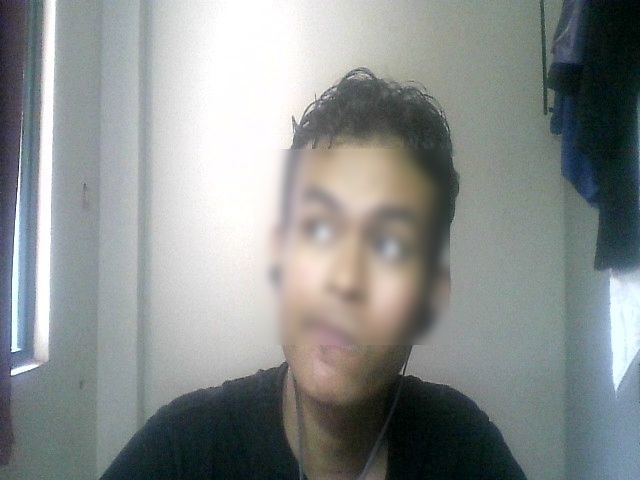

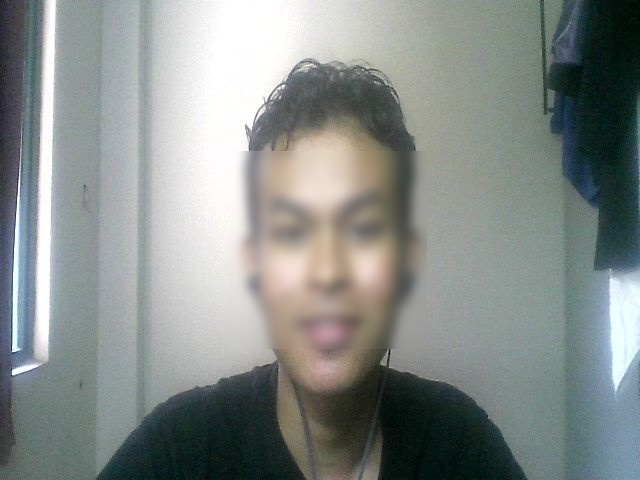

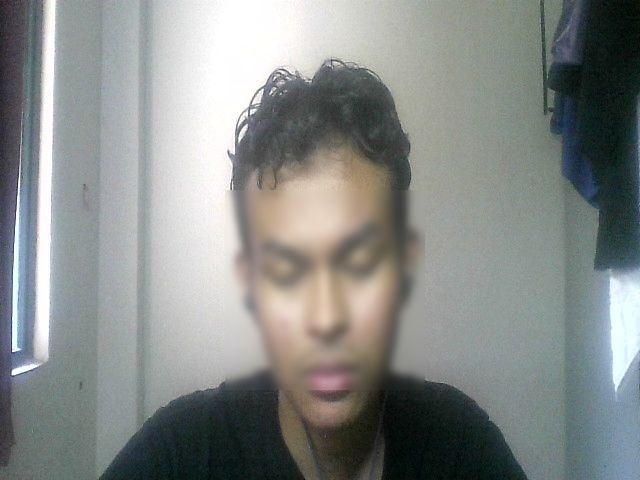

In [20]:
try:
  for i in range(3):
    filename = take_photo('photo_{}.jpg'.format(i+1))
    print('Saved to {}'.format(filename))
    # Show the image which was just taken
  for i in range(3):
    display(Image('photo_{}.jpg'.format(i+1)))

except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))